In [1]:
import torch
print(torch.__version__)  #注意是双下划线

1.9.0+cu102


In [2]:
import torch
import torch.nn as nn
import torchvision

from torch.utils.data import (
    Dataset,
    DataLoader,
)

from torchvision.datasets import ImageFolder
from torchvision.transforms import (
    RandomResizedCrop,
    RandomHorizontalFlip,
    ColorJitter,
    RandomGrayscale,
    RandomApply,
    Compose,
    GaussianBlur,
    ToTensor,
)
import torchvision.models as models
import os
import glob
import time
from skimage import io
import matplotlib.pyplot as plt

In [3]:
print(f'Torch-Version {torch.__version__}')
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'DEVICE: {DEVICE}')
print(torch.cuda.device_count())

Torch-Version 1.9.0+cu102
DEVICE: cuda
2


In [4]:
def get_complete_transform(output_shape, kernel_size, s=1.0):
    """
    The color distortion transform.
    
    Args:
        s: Strength parameter.
    
    Returns:
        A color distortion transform.
    """
    rnd_crop = RandomResizedCrop(output_shape)
    rnd_flip = RandomHorizontalFlip(p=0.5)
    
    color_jitter = ColorJitter(0.8*s, 0.8*s, 0.8*s, 0.2*s)
    rnd_color_jitter = RandomApply([color_jitter], p=0.8)
    
    rnd_gray = RandomGrayscale(p=0.2)
    gaussian_blur = GaussianBlur(kernel_size=kernel_size)
    rnd_gaussian_blur = RandomApply([gaussian_blur], p=0.5)
    to_tensor = ToTensor()
    image_transform = Compose([
        to_tensor,
        rnd_crop,
        rnd_flip,
        rnd_color_jitter,
        rnd_gray,
        rnd_gaussian_blur,
    ])
    return image_transform


class ContrastiveLearningViewGenerator(object):
    """Take two random crops of one image as the query and key.
        取一个图像的两个随机裁剪作为查询和关键字"""

    def __init__(self, base_transform, n_views=2):
        self.base_transform = base_transform
        self.n_views = n_views

    def __call__(self, x):
        views = [self.base_transform(x) for i in range(self.n_views)]
        return views

In [5]:
class CustomDataset(Dataset):
    """Leaves Dataset"""

    def __init__(self, list_images, transform=None):
        """
        Args:
            list_images (list): List of all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.list_images = list_images
        self.transform = transform

    def __len__(self):
        return len(self.list_images)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        img_name = self.list_images[idx]
        image = io.imread(img_name)
        if self.transform:
            image = self.transform(image)

        return image

In [6]:
# The size of the images
output_shape = [224,224]
kernel_size = [23,23] # 10% of the output_shape

# The custom transform
base_transforms = get_complete_transform(output_shape=output_shape, 
                                         kernel_size=kernel_size, s=1.0)
custom_transform = ContrastiveLearningViewGenerator(base_transform=base_transforms)

flowers_ds = CustomDataset(
    list_images=glob.glob("./leaves_data(20%_50%_10%_20%)/label/*/*.jpg"),# simclr Train
    transform=custom_transform
)

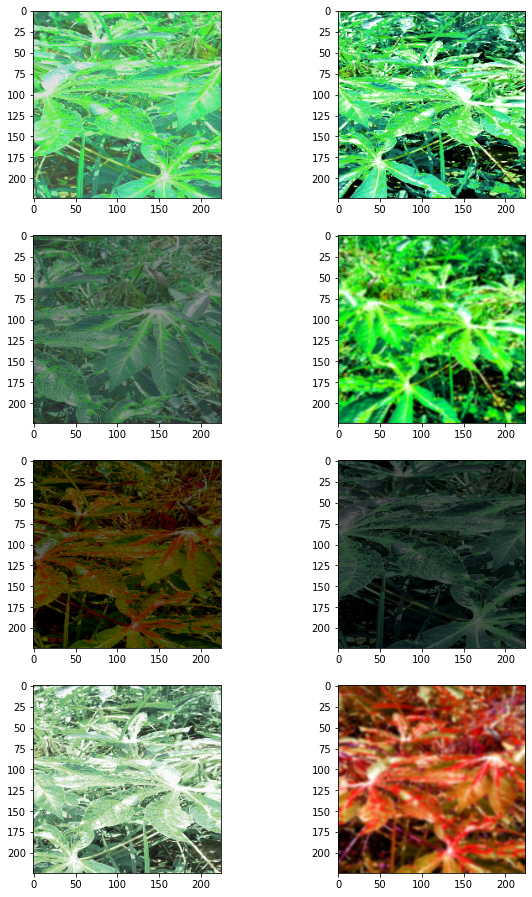

In [7]:
plt.figure(figsize=(10,20))
def view_data(flowers, index):
    for i in range(1,5):
        images = flowers[index]
        view1, view2 = images
        plt.subplot(5,2,2*i-1)
        plt.imshow(view1.permute(1,2,0))
        plt.subplot(5,2,2*i)
        plt.imshow(view2.permute(1,2,0))

view_data(flowers_ds,2000)

In [8]:
BATCH_SIZE = 32

# Building the data loader
simclr_train_dl = torch.utils.data.DataLoader(
    flowers_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=os.cpu_count(),
    drop_last=True,
    pin_memory=True,
)

In [9]:
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
    def forward(self, x):
        return x

class SimCLR(nn.Module):
    def __init__(self, linear_eval=False):
        super().__init__()
        self.linear_eval = linear_eval
        resnet18 = models.resnet18(pretrained=False)
        resnet18.fc = Identity()
        self.encoder = resnet18
        self.projection = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 256)
        )
    def forward(self, x):
        if not self.linear_eval:
            x = torch.cat(x, dim=0)
        
        encoding = self.encoder(x)
        projection = self.projection(encoding) 
        return projection

In [10]:
LABELS = torch.cat([torch.arange(BATCH_SIZE) for i in range(2)], dim=0)
LABELS = (LABELS.unsqueeze(0) == LABELS.unsqueeze(1)).float() # Creates a one-hot with broadcasting
LABELS = LABELS.to(DEVICE) #128,128

def cont_loss(features, temp):
    """
    The NTxent Loss.
    
    Args:
        z1: The projection of the first branch
        z2: The projeciton of the second branch
    
    Returns:
        the NTxent loss
    """
    similarity_matrix = torch.matmul(features, features.T) # 128, 128
    # discard the main diagonal from both: labels and similarities matrix
    mask = torch.eye(LABELS.shape[0], dtype=torch.bool).to(DEVICE)
    # ~mask is the negative of the mask
    # the view is required to bring the matrix back to shape
    labels = LABELS[~mask].view(LABELS.shape[0], -1) # 128, 127
    similarity_matrix = similarity_matrix[~mask].view(similarity_matrix.shape[0], -1) # 128, 127

    # select and combine multiple positives
    positives = similarity_matrix[labels.bool()].view(labels.shape[0], -1) # 128, 1

    # select only the negatives
    negatives = similarity_matrix[~labels.bool()].view(similarity_matrix.shape[0], -1) # 128, 126

    logits = torch.cat([positives, negatives], dim=1) # 128, 127
    labels = torch.zeros(logits.shape[0], dtype=torch.long).to(DEVICE)

    logits = logits / temp
    return logits, labels

In [11]:
from torchvision.transforms import (
    CenterCrop,
    Resize
)
#resize = Resize(255)
#ccrop = CenterCrop(224)
ttensor = ToTensor()

custom_transform = Compose([
    #resize,
    #ccrop,
    ttensor,
])

leaves_ds = ImageFolder(
    root="./leaves_data(20%_50%_10%_20%)/no_label/", #Resnet18 train
    transform=custom_transform
)

# val_ds = ImageFolder(
#     root="./leaves_data(20%_50%_10%_20%)/val/", #val
#     transform=custom_transform
# )


nu_classes = len(leaves_ds.classes)
print(nu_classes)
BATCH_SIZE = 32

# 有标签的数据集
train_dl = torch.utils.data.DataLoader(
    leaves_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=os.cpu_count(),
    drop_last=True,
    pin_memory=True,
)
# val
# val_dl = torch.utils.data.DataLoader(
#     val_ds,
#     batch_size=BATCH_SIZE,
#     shuffle=False,
#     num_workers=os.cpu_count(),
#     drop_last=True,
#     pin_memory=True,
# )

5


In [12]:
# -------------------------模型选择，优化方法， 学习率策略----------------------
model = models.resnet18(pretrained=False)

# 全连接层的输入通道in_channels个数
num_fc_in = model.fc.in_features

# 改变全连接层，2分类问题，out_features = 2
model.fc = nn.Linear(num_fc_in, 5)

# 模型迁移到CPU/GPU
#model = model.to(DEVICE)

# 定义权重
weight_CE = torch.FloatTensor([0.1,1,1,1,1])

# 定义损失函数
loss_fc = nn.CrossEntropyLoss(weight=weight_CE).to(DEVICE)

# 选择优化方法
#optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)




In [13]:
# 用两块GPU
# simclr_model = SimCLR()
# if torch.cuda.device_count() > 1:
#     simclr_model = torch.nn.DataParallel(simclr_model)
#     model = torch.nn.DataParallel(model)
#     print("Use", torch.cuda.device_count(), 'gpus')

In [14]:
model = model.to(DEVICE)
simclr_model = SimCLR().to(DEVICE) # 上传到GPU
criterion = nn.CrossEntropyLoss().to(DEVICE)
simclr_optimizer = torch.optim.Adam(simclr_model.parameters())
optimizer = torch.optim.Adam(model.parameters())

In [ ]:
EPOCHS = 50
for epoch in range(EPOCHS):
    t0 = time.time()
    running_loss = 0.0
    for views,element in zip(enumerate(simclr_train_dl),enumerate(train_dl)):
        i,views = views
        #print([view.to(DEVICE) for view in views])
        projections = simclr_model([view.to(DEVICE) for view in views])
        logits, labels = cont_loss(projections, temp=2)
        simclr_loss = criterion(logits, labels)
        
        i,element = element
        image,label = element
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        pred = model(image)
        
        #resnet18 和 simclr 模型的损失相加
        summary_loss = criterion(pred, label)+simclr_loss
        #优化simclr模型
        simclr_optimizer.zero_grad()
        #优化resnet18模型
        optimizer.zero_grad()
        #反向传播计算
        summary_loss.backward()
        
        optimizer.step()
        simclr_optimizer.step()  
        # print statistics
        running_loss += summary_loss.item()
        if i % 10 == 9:    # print every 10 mini-batches
            print(f'EPOCH: {epoch+1} BATCH: {i+1} LOSS: {(running_loss/100):.4f} ')
            running_loss = 0.0
    print(f'Time taken: {((time.time()-t0)/60):.3f} mins')

/root/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


EPOCH: 1 BATCH: 10 LOSS: 0.6690 
EPOCH: 1 BATCH: 20 LOSS: 0.5393 
EPOCH: 1 BATCH: 30 LOSS: 0.5261 
EPOCH: 1 BATCH: 40 LOSS: 0.5205 
EPOCH: 1 BATCH: 50 LOSS: 0.5191 
EPOCH: 1 BATCH: 60 LOSS: 0.5281 
EPOCH: 1 BATCH: 70 LOSS: 0.5239 
EPOCH: 1 BATCH: 80 LOSS: 0.5390 
EPOCH: 1 BATCH: 90 LOSS: 0.5260 
EPOCH: 1 BATCH: 100 LOSS: 0.5172 
EPOCH: 1 BATCH: 110 LOSS: 0.5283 
EPOCH: 1 BATCH: 120 LOSS: 0.5171 
EPOCH: 1 BATCH: 130 LOSS: 0.5175 
Time taken: 1.774 mins
EPOCH: 2 BATCH: 10 LOSS: 0.5146 
EPOCH: 2 BATCH: 20 LOSS: 0.5256 
EPOCH: 2 BATCH: 30 LOSS: 0.5226 
EPOCH: 2 BATCH: 40 LOSS: 0.5219 
EPOCH: 2 BATCH: 50 LOSS: 0.5098 
EPOCH: 2 BATCH: 60 LOSS: 0.5126 
EPOCH: 2 BATCH: 70 LOSS: 0.5192 
EPOCH: 2 BATCH: 80 LOSS: 0.5272 
EPOCH: 2 BATCH: 90 LOSS: 0.5140 
EPOCH: 2 BATCH: 100 LOSS: 0.5111 
EPOCH: 2 BATCH: 110 LOSS: 0.5085 
EPOCH: 2 BATCH: 120 LOSS: 0.5249 
EPOCH: 2 BATCH: 130 LOSS: 0.5256 
Time taken: 1.649 mins
EPOCH: 3 BATCH: 10 LOSS: 0.5163 
EPOCH: 3 BATCH: 20 LOSS: 0.5118 
EPOCH: 3 BATCH: 30 LOS

In [ ]:
torch.save(model.state_dict(), './model(Experiment_1(0.5_label)).pth')
torch.save(simclr_model.state_dict(), './simclr_model(Experiment_1(0.5_label)).pth')

In [ ]:
#测试

#resize = Resize(255)
ccrop = CenterCrop(224)
ttensor = ToTensor()

custom_transform = Compose([
    #resize,
    #ccrop,
    ttensor,
])

test_ds = ImageFolder(
    root="./leaves_data(20%_50%_10%_20%)/test",#test Path
    transform=custom_transform
)

nu_classes = len(test_ds.classes)
print(nu_classes)
BATCH_SIZE = 32

# Building the data loader
test_dl = torch.utils.data.DataLoader(
    test_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    drop_last=True,
    pin_memory=True,
)

In [ ]:
EPOCHS = 1
total = 0
correct = 0
ACC = 0
model.eval()
with torch.no_grad():
    for i, element in enumerate(test_dl):
        image, label = element
        #print(image)
        print('label:',label)
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        pred = model(image)
        _, predicted = pred.max(1)
        print('predicted:',predicted)
        total = total + label.size(0)
        correct = correct + predicted.eq(label).sum().item()
        print(total)
        #print statistics
        #print(f'Time taken: {((time.time()-t0)/60):.3f} mins')
        
    print(f' ACC:{100. * correct / total} total:{total}')
    ACC = 100. * correct / total

In [ ]:
ACC